# IGRINS CA1 R3 blaze model

Here we finally get to our desired result: the blaze envelope at R3.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format='retina'

### Fixed physical properties

In [ ]:
#Fix all this terminology after defining the methods in paper!!! Ignore the following cell, only use as reference:

In [ ]:
# sigma = 109.9 # 109.9 is M band, 27.36 is IGRINS# micron

# groove_top_width = sigma-64.9 # micron

# # blaze_angle_radians = np.arctan(3) # radians
# # blaze_angle_degrees = np.degrees(blaze_angle_radians)
# blaze_angle_degrees = 76.0

# Assume testing in back-surface reflection in visible light!

# wavelength_micron = 0.632 # micron

# Fix the angle of incidence for now.

# theta_i_degrees = 76.0

## Make the blaze envelope function

The function takes in these 5 **scalar** inputs:

- blaze angle $\theta_b$ 
- groove constant (groove spacing) $\sigma$
- groove top width ($t$)
- incidence angle ($\alpha$)
- wavelength $\lambda$

... and it outputs these 3 **vector** outputs:

- The list of diffraction order indices $\mathbf{m}$
- The list of angular output locations $(\mathbf{\beta_m})$
- The fluxes ($\mathbf{f_m}$)

where the length of the vector (the number of items in the list) is $N_{orders}$.  

We anticipate about $N_{orders}\sim100$.  We will hone in on only 3 or 4 of those orders at any given time.

Define the grating equation:

$\theta_m = \arcsin{\left( \sin\theta_i -\frac{m\lambda}{\sigma}\right )}$  

In [2]:
def grating_equation(groove_constant, incidence_angle, wavelength_micron):
    """Evaluate the grating equation for a specified grating and measurement setup
    
    Note: all angles are in degrees, all lengths in micron
    
    Returns:
    -------
        betas (numpy array): Angular locations of the diffracted orders
    """
    max_m = np.floor(2 * groove_constant / wavelength_micron)
    m_vector = np.arange(-max_m, max_m+1, 1)
    
    incidence_angle_radians = np.radians(incidence_angle)
    theta_m_radians = np.arcsin(np.sin(incidence_angle_radians) - 
                                m_vector*(wavelength_micron)/groove_constant)
    theta_m_degrees = np.degrees(theta_m_radians)
    
    
    return (m_vector, theta_m_degrees)

In [3]:
def projected_groove_size(groove_constant, groove_top_width, incidence_angle):
    """ The projected size of the illuminated groove
    
    Note:
    -----
    Function formerly known as "beam_waist", renamed to disambiguate
    
    Parameters:
    -----------
    sigma: The groove spacing or groove pitch (micron)
    groove_top_width: The groove top or 'dam' unique to Si grating
        development, they cause shadowing (micron)
    incidence_angle: The input angle, as measured from the 
        grating normal (degrees)
    """
    
    A_micron = groove_constant - groove_top_width
    incidence_angle_radians = np.radians(incidence_angle)
    
    output = A_micron * np.cos(incidence_angle_radians)
    return output

### Now we compute the "blaze envelope"

In [4]:
def blaze_modulation(blaze_angle, groove_constant, groove_top_width, 
                     incidence_angle, wavelength_micron):
    """Compute the blaze modulation given the grating geometry and measurement
    
    Returns:
    -------
        m_vector, beta_angle, flux_value (numpy arrays)
    """
    
    #Call grating equation function:
    m_vector, beta_m_degrees = grating_equation(groove_constant, incidence_angle, wavelength_micron)
    
    #Call projected_groove_size function:
    A_projected = projected_groove_size(groove_constant, groove_top_width, incidence_angle)
    
    #Use returns from those two functions (and some unit conversions) 
    beta_m_radians = np.deg2rad(beta_m_degrees)
    incidence_angle_radians = np.deg2rad(incidence_angle)
    blaze_angle_radians = np.deg2rad(blaze_angle)
    
    #...to compute blaze modulation:
    relative_flux_values = np.sinc((A_projected*np.pi/(wavelength_micron)*
                np.sin(beta_m_radians-blaze_angle_radians)))**2 ###double check sign on sin arg
    
    #Sin should evaluate to 0 when at blaze angle
    
    
    return (m_vector, beta_m_degrees, relative_flux_values)

In [15]:

#compute values!
m_vector, beta_m_degrees, relative_flux_values = blaze_modulation(76, 109.9, 45, -76, 0.6328)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arcsin
  from ipykernel import kernelapp as app


In [16]:
# m_vector

In [17]:
brightest_index = np.nanargmax(relative_flux_values)
np.nanmax(relative_flux_values)
# m_vector[brightest_index]

0.9914896292928677

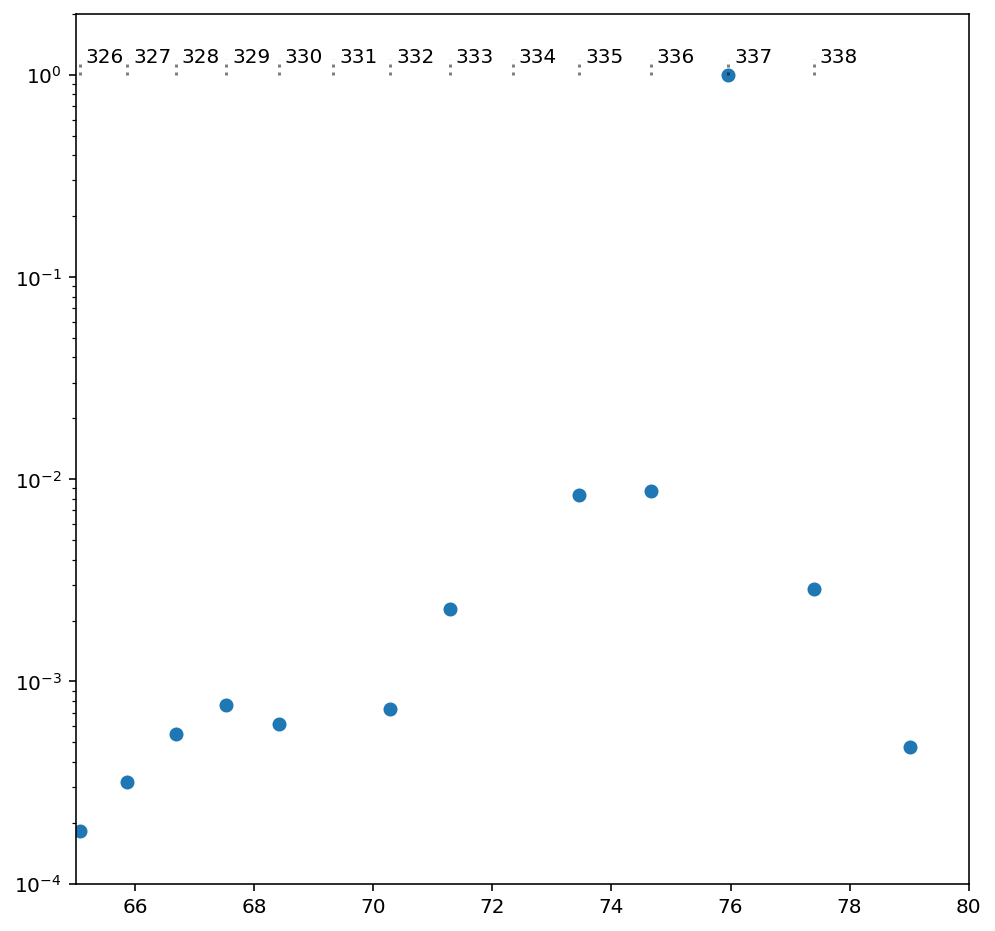

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(beta_m_degrees, relative_flux_values)
# plt.xlim(50,80)

x_lo, x_hi =(65,80)
plt.xlim(x_lo, x_hi)
plt.yscale('log')
plt.ylim(0.0001, 2)
# plt.ylim(-0.2, 1.5)
for m, beta_m in zip(m_vector, beta_m_degrees):
    if np.isfinite(beta_m) & (beta_m>x_lo) & (beta_m < x_hi-1):
        plt.text(beta_m+0.1, 1.15, "{:d}".format(-int(m)), rotation='horizontal')
        plt.plot([beta_m, beta_m], [1.0, 1.2], color='k', alpha=0.5, 
                 linestyle='dotted')

plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.step(angular_grid_degrees, blazed_groove_top_diffraction, where='mid')
plt.step(angular_grid_degrees, blaze_modulation, where='mid')

x_lo, x_hi = (-90, -50)
plt.xlim(x_lo, x_hi)
plt.ylim(0, 1.2)

for m, theta_m in zip(m_vector, theta_m_degrees):
    if np.isfinite(theta_m) & (theta_m>x_lo) & (theta_m < x_hi-1):
        plt.text(theta_m+0.1, 1.15, "{:d}".format(-int(m)), rotation='horizontal')
        plt.plot([theta_m, theta_m], [1.0, 1.2], color='k', alpha=0.5, 
                 linestyle='dotted')

plt.xlabel(r'$\theta \; (^\circ)$')
plt.ylabel(r'$\frac{I(\theta)}{I_0}$', fontsize=18)
plt.title('Blazed diffraction from IGRINS CA-1 at R3 for 632.8 nm back surface illumination'.format(beam_size_mm) );

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

plt.savefig('../../figures/IGRINS_CA1_R3_blaze.png', dpi=300, bbox_inches='tight');

Let's look at the whole range in log space

In [ ]:
plt.figure(figsize=(14, 4))
plt.step(angular_grid_degrees, blazed_groove_top_diffraction)
plt.step(angular_grid_degrees, blaze_modulation)

x_lo, x_hi = (-90, -50)
plt.xlim(x_lo, x_hi)
plt.ylim(1e-4, 2)
plt.yscale('log')

for m, theta_m in zip(m_vector, theta_m_degrees):
    if np.isfinite(theta_m) & (theta_m>x_lo) & (theta_m < x_hi) & (np.mod(m, 1) ==0):
        plt.text(theta_m+0.1, 1.15, "{:d}".format(-int(m)), rotation='horizontal')
        plt.plot([theta_m, theta_m], [0.01, 1.2], color='k', alpha=0.5, 
                 linestyle='dotted')

plt.xlabel(r'$\theta \; (^\circ)$')
plt.ylabel(r'$\frac{I(\theta)}{I_0}$', fontsize=18)
plt.title('Blazed diffraction from IGRINS groove tops'.format(beam_size_mm) );

Awesome!  Appears correct!